<a href="https://colab.research.google.com/github/alessandrou24/ColabGithub/blob/main/lunarlander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definicion del problema

 Lunar Lander es un ejercicio de Gymnasium en el que el objetivo es aterrizar una nave espacial de manera controlada sobre una zona específica en la superficie lunar. El agente controla la nave utilizando propulsores para ajustar su posición, velocidad y orientación en un entorno con gravedad y física realista. El desafío radica en maniobrar correctamente la nave para lograr un aterrizaje suave sin chocar o salir de los límites del área de aterrizaje.  

Un episodio en Lunar Lander finaliza en tres casos: si la nave se estrella, si se sale de los limites del mapa o si no esta activa(no se mueve y no colisiona con nada)


Por cada paso, se otorga recompensa en base a la siguientes reglas:

- Aumenta o disminuye según la proximidad de la nave a la plataforma de aterrizaje.
- Aumenta o disminuye dependiendo de la velocidad de la nave (más lenta es mejor).
- Disminuye si la nave está inclinada (el ángulo no es horizontal).
- Aumenta en 10 puntos por cada pata que toque el suelo.
- Disminuye en 0.03 puntos por cada cuadro en el que se active un motor lateral.
- Disminuye en 0.3 puntos por cada cuadro en el que se active el motor principal.
- El episodio recibe una recompensa adicional de -100 o +100 puntos por estrellarse o aterrizar con éxito, respectivamente.

Un episodio se considera resuelto si alcanza al menos 200 puntos.

# Autores
- Alejandro López Cuéllar
- Miguel Ángel Vera Frutos
- Alejandro Belda Fernández


# Importacion de librerias

In [ ]:
! git clone

In [ ]:
! pip install swig
! pip install gymnasium[box2d]

In [ ]:
! pip install numpy matplotlib tqdm gymnasium moviepy torch


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random
from gymnasium import ObservationWrapper
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip  # Import from correct locationimport torch
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
import os
import gc
from collections import defaultdict
import itertools
import pickle  # Para guardar el agente entrenado


# Reproducbilidad

In [ ]:
semilla = 42
np.random.seed(semilla)
np.random.default_rng(semilla)
random.seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)
torch.manual_seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [ ]:
gc.collect()

30

# Metodos Auxiliares

Este metodo simula un episodio  utilizando la política aprendida por un agente basado en redes neuronales. Inicializa el entorno, pone la red en modo evaluación y, en cada paso, convierte la observación en un tensor, predice la mejor acción con la red neuronal, guarda la relación estado-acción en un diccionario (`pi_star`), y avanza en el entorno hasta que el episodio termine. Además, registra el historial de acciones (`actions_history`) y captura imágenes (`frames`) para visualizar la trayectoria del agente. Finalmente, devuelve estos datos para analizar el comportamiento del agente.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Este metodo simula un episodio  utilizando la política aprendida por un agente basado en redes neuronales. Inicializa el entorno, pone la red en modo evaluación y, en cada paso, convierte la observación en un tensor, predice la mejor acción con la red neuronal, guarda la relación estado-acción en un diccionario (`pi_star`), y avanza en el entorno hasta que el episodio termine. Además, registra el historial de acciones (`actions_history`) y captura imágenes (`frames`) para visualizar la trayectoria del agente. Finalmente, devuelve estos datos para analizar el comportamiento del agente.

In [ ]:
def pi_star_from_Deep(env, agent, semilla=42):
    frames = []
    done = False
    pi_star = {}

    obs, info = env.reset(seed=semilla)
    img = env.render()
    frames.append(img)
    actions_history = ""

    # Poner la red en modo evaluación
    agent.policy_net.eval()

    while not done:
        # Preparar el estado para la red
        state = obs  # Para claridad
        with torch.no_grad():
            if not isinstance(state, torch.Tensor):
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            else:
                # Asegurar que el estado tiene la dimensión de batch
                state_tensor = state if state.dim() > 1 else state.unsqueeze(0)

            # Obtener acción óptima según la política actual
            action = agent.policy_net(state_tensor).argmax(dim=1).item()

        # Guardar el mapeo estado->acción (política óptima)
        state_key = tuple(map(float, obs)) if isinstance(obs, (list, np.ndarray)) else obs
        pi_star[state_key] = action
        actions_history += f"{action}, "

        # Avanzar en el entorno
        obs, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated

    return pi_star, actions_history, frames

El metodo `plot` se encarga de generar gráficos para analizar el rendimiento de un agente de aprendizaje por refuerzo. Calcula la media móvil de la proporción de recompensas obtenidas y del tamaño de los episodios usando una ventana deslizante (`window_size`) para suavizar las fluctuaciones. Luego, en un gráfico de dos subgráficos, muestra la evolución de las recompensas y los tamaños de los episodios a lo largo del tiempo, comparando los valores originales con sus medias móviles para visualizar tendencias y estabilidad en el aprendizaje del agente. Finalmente, ajusta el diseño y muestra los gráficos.

In [ ]:
def plot(list_stats, episode_sizes, window_size=100):
    # Creamos una lista de índices para el eje x
    indices = list(range(len(list_stats)))

    # Función para calcular la media móvil
    def calculate_moving_avg(data, window_size):
        moving_avg = []
        for i in range(len(data)):
            if i < window_size:
                moving_avg.append(sum(data[:i+1]) / (i+1))
            else:
                moving_avg.append(sum(data[i-window_size:i+1]) / window_size)
        return moving_avg

    # Calculamos la media móvil para la proporción de recompensas
    moving_avg_rewards = calculate_moving_avg(list_stats, window_size)

    # Calculamos la media móvil para el tamaño del episodio
    moving_avg_sizes = calculate_moving_avg(episode_sizes, window_size)

    # Creamos el gráfico de la proporción de recompensas y la media móvil
    plt.figure(figsize=(12, 6))

    # Gráfico de la proporción de recompensas y la media móvil
    plt.subplot(2, 1, 1)
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.3, color='blue')  # Más transparente
    plt.plot(indices, moving_avg_rewards, label=f'Media móvil (ventana={window_size})', color='red', linewidth=2)  # Más opaco
    plt.title('Proporción de recompensas y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.legend()
    plt.grid(True)

    # Gráfico del tamaño del episodio y su media móvil
    plt.subplot(2, 1, 2)
    plt.plot(indices, episode_sizes, label='Tamaño del episodio', alpha=0.3, color='green')  # Más transparente
    plt.plot(indices, moving_avg_sizes, label=f'Media móvil (ventana={window_size})', color='orange', linewidth=2)  # Más opaco
    plt.title('Tamaño del Episodio y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Tamaño')
    plt.legend()
    plt.grid(True)

    # Ajustamos el espacio entre los subplots
    plt.tight_layout()

    # Mostramos los gráficos
    plt.show()

El metodo `create_gif` se encarga de crear un gif a partir de una lista de imagenes, este gif sera un video en donde se ve si el agente entrenado previamente es capaz de completar el juego.

In [ ]:
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

# Cargamos el entorno de Gymnasium

In [ ]:
#@title Cargamos el entorno
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env.reset(seed=semilla)

(array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
        -0.05269805,  0.        ,  0.        ], dtype=float32),
 {})

Mostramos una imagen del problema

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
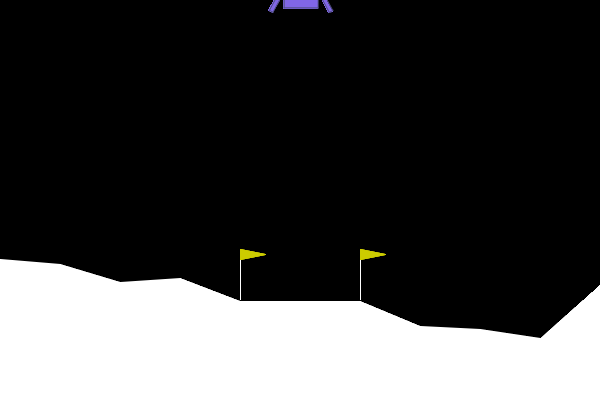

In [ ]:
env.render()

Mostramos el espacio de acciones

In [ ]:
env.action_space

Discrete(4)



1. **Acción 0** - No hacer nada (Ningún propulsor activado).  
2. **Acción 1** - Encender el propulsor principal (hacia arriba).  
3. **Acción 2** - Encender el propulsor izquierdo (empuja la nave hacia la derecha).  
4. **Acción 3** - Encender el propulsor derecho (empuja la nave hacia la izquierda).  



Mostramos el espacio de observacion

In [ ]:
env.observation_space, env.observation_space.low,  env.observation_space.high

(Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ], (8,), float32),
 array([ -2.5      ,  -2.5      , -10.       , -10.       ,  -6.2831855,
        -10.       ,  -0.       ,  -0.       ], dtype=float32),
 array([ 2.5      ,  2.5      , 10.       , 10.       ,  6.2831855,
        10.       ,  1.       ,  1.       ], dtype=float32))


1. **Posición X** - Coordenada horizontal de la nave.  
2. **Posición Y** - Coordenada vertical de la nave.  
3. **Velocidad X** - Velocidad horizontal de la nave.  
4. **Velocidad Y** - Velocidad vertical de la nave.  
5. **Ángulo** - Inclinación de la nave en radianes.  
6. **Velocidad Angular** - Velocidad de rotación de la nave.  
7. **Estado del perno izquierdo** - 1 si ha tocado el suelo, 0 si no.  
8. **Estado del perno derecho** - 1 si ha tocado el suelo, 0 si no.  



# Deep Q-Learning

Deep Q-Learning es un algoritmo de aprendizaje por refuerzo que utiliza redes neuronales profundas para aproximar la función de valor Q, la cual estima la recompensa esperada para cada par de estado-acción en un entorno dado. El objetivo del algoritmo es aprender una política que maximice la recompensa acumulada a lo largo del tiempo. Utiliza una política epsilon-greedy para equilibrar la exploración y la explotación, donde el agente selecciona una acción aleatoria con una probabilidad epsilon o la acción con el valor Q más alto según la red neuronal. Durante el entrenamiento, los Q-values se actualizan utilizando la ecuación de Bellman, y se emplea una red objetivo separada para calcular los Q-values futuros, lo que ayuda a estabilizar el proceso de aprendizaje al reducir las oscilaciones y las actualizaciones inestables. Deep Q-Learning ha sido muy exitoso en entornos con espacios de acción grandes y complejos, como juegos de video o simulaciones, donde las redes neuronales son capaces de manejar la gran cantidad de datos y patrones involucrados.

Dado que el problema presenta una alta complejidad, emplearemos métodos de aproximación no lineales para su resolución. El uso de métodos tabulares requeriría una discretización del espacio de observación, por ejemplo, mediante *tiling*. Sin embargo, debido a la gran cantidad de características del problema, esto generaría un espacio de observación extremadamente grande. Como referencia, en el problema de *Mountain Car*, que solo tiene dos características, la discretización utilizada resultó en un espacio de observación de tamaño 4000. En nuestro caso, esta solución sería inviable. Más adelante, también explicaremos por qué los métodos de aproximación lineales tampoco serían adecuados.  

Por ello, optaremos por métodos de aproximación no lineales como *Deep Q-Learning* y *Deep Sarsa*. Aunque el uso de redes neuronales implica un mayor costo computacional, sigue siendo una alternativa más eficiente que la discretización tabular. Además, dado que el problema presenta una complejidad considerable, la capacidad de optimización y actualización de las redes neuronales permite una mejor adaptación a la tarea.

Inicializamos el device a usar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Definimos la red neuronal. Como podemos ver es de tres capas. La capa de entrada (`fc1`) tiene `input_size (las caracteristicas)` neuronas y se conecta a una capa oculta de 128 neuronas, seguida de otra capa oculta de 64 neuronas (`fc2`), ambas activadas con la función ReLU. Finalmente, la capa de salida (`fc3`) tiene `output_size(las acciones)` neuronas y no aplicamos función de activación.

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)



    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


La clase `Buffer` implementa una memoria de repetición que se utilizara para almacenar experiencias del agente y reutilizarlas en el entrenamiento.


In [ ]:


class Buffer:

    def __init__(self, capacity):
        """
        Inicializa la memoria de repetición con una capacidad máxima y una lista vacía para almacenar las experiencias.

        Parámetros:
        - capacity (int): La capacidad máxima del buffer, es decir, cuántas experiencias se pueden almacenar.

        No devuelve ningún valor.
        """
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        """
        Agrega una nueva experiencia al buffer. Si el buffer está lleno, sobrescribe la experiencia más antigua.

        Parámetros:
        - state (tuple o array): El estado en el que se encuentra el agente.
        - action (int o float): La acción tomada por el agente.
        - reward (float): La recompensa obtenida por la acción tomada.
        - next_state (tuple o array): El siguiente estado después de ejecutar la acción.
        - done (bool): Indica si el episodio ha terminado.

        No devuelve ningún valor.
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Muestra un batch aleatorio de experiencias almacenadas en el buffer.

        Parámetros:
        - batch_size (int): El número de experiencias a obtener en el batch.

        Retorna:
        - Un conjunto de elementos desempaquetados: (states, actions, rewards, next_states, dones).
        """
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)  # Desempaca los valores correctamente

    def __len__(self):
        """
        Devuelve el número de experiencias almacenadas actualmente en el buffer.

        Retorna:
        - (int): El número de elementos en el buffer.
        """
        return len(self.buffer)



La clase `DQN` implementa un agente de Aprendizaje por Refuerzo basado en el algoritmo Deep Q Learning. En donde se utiliza una red neuronal para aproximar la función Q y realiza optimización utilizando un buffer de repetición de experiences (memoria).

Definimos el agente

In [ ]:
class DQN:


    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=64):
        """
        Inicializa el agente DQN, configurando los parámetros de la red neuronal, optimizador y el buffer de experiencias.

        Parámetros:
        - env (OpenAI Gym environment): El entorno con el que interactúa el agente.
        - alpha (float): La tasa de aprendizaje del optimizador.
        - gamma (float): El factor de descuento para las recompensas futuras.
        - epsilon (float): La probabilidad inicial de seleccionar una acción aleatoria.
        - epsilon_decay (float): La tasa de decrecimiento de epsilon.
        - epsilon_min (float): El valor mínimo de epsilon.
        - buffer_size (int): El tamaño máximo del buffer de repetición.
        - batch_size (int): El tamaño del lote de muestras para el entrenamiento.

        No devuelve ningún valor.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = Buffer(self.buffer_size)

        self.n_actions = env.action_space.n  # Número de acciones posibles en el entorno
        self.state_size = env.observation_space.shape[0]  # Tamaño del espacio de observación

        # Inicializar redes neuronales: la política y la red objetivo
        self.policy_net = NN(self.state_size, self.n_actions).to(device)
        self.target_net = NN(self.state_size, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # La red objetivo está en modo evaluación
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)  # Optimizador

    def select_action(self, state):
        """
        Selecciona una acción basada en el estado actual utilizando una política epsilon-greedy.

        Parámetros:
        - state (array o tensor): El estado actual del agente.

        Retorna:
        - action (int): La acción seleccionada por el agente.
        """
        # Selección de acción aleatoria con probabilidad epsilon
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)

        # Convertir el estado a tensor si no lo es y añadir dimensión de batch
        with torch.no_grad():
            if not isinstance(state, torch.Tensor):
                state = torch.FloatTensor(state).unsqueeze(0).to(device)
            else:
                if state.dim() == 1:
                    state = state.unsqueeze(0)

        # Devuelve la acción con el valor Q más alto
        return self.policy_net(state).argmax(dim=1).item()

    def optimize(self):
        """
        Optimiza la red neuronal usando un batch de experiencias del buffer de repetición.

        Este método realiza los siguientes pasos:
        - Extrae un batch de experiencias del buffer.
        - Calcula los Q-valores y valores esperados.
        - Calcula el error de predicción (loss) y realiza un paso de optimización.

        No devuelve ningún valor.
        """
        # Verificar si hay suficientes muestras en el buffer
        if len(self.memory) < self.batch_size:
            return

        # Extraer una muestra del buffer de repetición
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convertir las muestras a tensores
        states = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)

        # Calcular los Q-valores actuales
        q_values = self.policy_net(states).gather(1, actions).squeeze()
        next_q_values = self.target_net(next_states).max(1)[0]  # Q-values de la red objetivo
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)  # Valor esperado Q

        # Calcular la función de pérdida (loss) y actualizar la red
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        """
        Decrece el valor de epsilon para reducir la probabilidad de acciones aleatorias a medida que el agente entrena.

        No recibe parámetros ni devuelve valores.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decae epsilon


En base a diversas pruebas hemos estimados que unos parametros optimos pueden ser los siguientes

In [ ]:
gamma = 0.99
alpha =  5e-4
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.95
buffer_size = int(1e5)
batch_size =  100
num_episodes = 4000

Inicialzamos el agente

In [ ]:
agent = DQN(env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size, batch_size)

In [ ]:
# --- Bucle principal de entrenamiento con DeepQLearning ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

# Bucle para cada episodio de entrenamiento
for episode in range(num_episodes):
    # Reiniciar el entorno y obtener el estado inicial
    state, _ = env.reset(seed=semilla)
    total_reward = 0  # Recompensa acumulada en el episodio
    episode_steps = 0  # Contador de pasos en el episodio

    # Bucle para cada paso dentro de un episodio
    while True:
        # Seleccionar una acción utilizando la política epsilon-greedy
        action = agent.select_action(state)

        # Ejecutar la acción en el entorno y obtener la siguiente observación y recompensa
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # Verificar si el episodio ha terminado

        # Almacenar la experiencia (estado, acción, recompensa, siguiente estado, si terminó) en el buffer
        agent.memory.push(state, action, reward, next_state, done)

        # Actualizar el estado actual para el siguiente paso
        state = next_state
        total_reward += reward  # Acumular la recompensa obtenida en este paso
        episode_steps += 1  # Contar los pasos del episodio

        # Terminar el episodio si se ha alcanzado el estado final
        if done:
            break

        # Si hay suficientes experiencias en el buffer, optimizar el modelo
        if len(agent.memory) > agent.batch_size:
            agent.optimize()  # Optimizar la red neuronal utilizando un batch del buffer

    # Reducir el valor de epsilon (exploración vs explotación)
    agent.decay_epsilon()

    # Almacenar la recompensa total y el número de pasos de este episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)

    # Actualizar la red objetivo cada 10 episodios (para mejorar la estabilidad)
    if episode % 10 == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

    # Imprimir información sobre el progreso del entrenamiento
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")


Episode 1/4000, total reward: -325.0768515077927
Episode 2/4000, total reward: -233.14896782532009
Episode 3/4000, total reward: -183.73332642611769
Episode 4/4000, total reward: -392.13057790760456
Episode 5/4000, total reward: 7.2468610306121946
Episode 6/4000, total reward: -282.10715361493436
Episode 7/4000, total reward: -445.4566049807377
Episode 8/4000, total reward: -493.6057545561448
Episode 9/4000, total reward: -328.0596840590139
Episode 10/4000, total reward: -213.15455212896086
Episode 11/4000, total reward: -128.9895334995865
Episode 12/4000, total reward: -121.13650387916977
Episode 13/4000, total reward: -248.0702774464768
Episode 14/4000, total reward: -90.55840049818491
Episode 15/4000, total reward: -237.2845497699842
Episode 16/4000, total reward: -125.47210331476445
Episode 17/4000, total reward: -81.10584151211987
Episode 18/4000, total reward: -116.73592749836213
Episode 19/4000, total reward: -257.8808220008407
Episode 20/4000, total reward: -235.9189443782516
E

Parece que el algoritmo se ajusta de buena manera al problema, un promedio de 165 refleja buenos resultados. Por lo que se podría decir que el algoritmo es capaz de aprender de manera exitosa. Ahora lo terminaremos de confirmar con el video y las graficas.

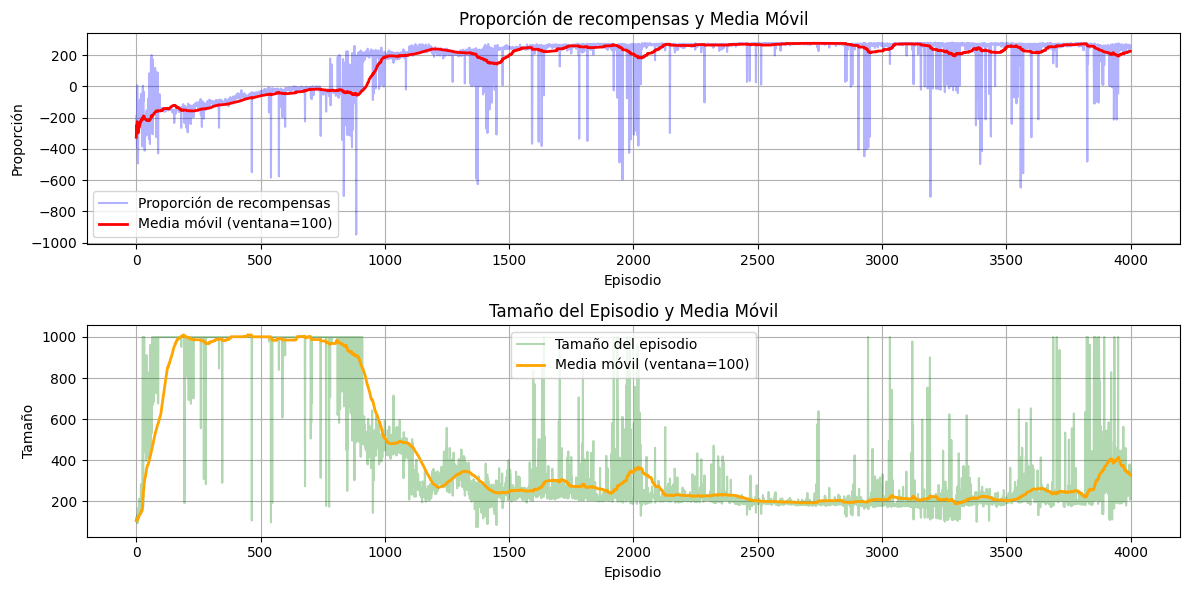

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)

En la primera grafica lo que podemos apreciar es como inicialmente el agente empieza a realizar el problema, como es obvio al ser el primero episodios obtiene recompensas bajas dado que no tiene la suficiente experiencia ni conocimiento. Sin embargo, sobre el episodio 1000 alcanza una política más que óptima y en general empieza a conseguir excelentes recompensas(sobre los 200), tiene algún mal episodio, pero esto se puede deber por ejemplo a la exploración. Por lo que al inicio, las recompensas son bajas y varían significativamente, pero con el tiempo aumentan y se estabilizan en valores positivos. Tambien se observa una transición más clara alrededor del episodio 1000, donde la recompensa promedio se estabiliza en valores altos, lo que indica que el agente ha aprendido una política efectiva. Aunque hay algunas caídas en la recompensa en ciertos momentos, la tendencia general es de mejora y estabilidad.

En la segunda gráfica se aprecia el cómo el agente inicialmente tiene episodios de bastantes pasos, de como podemos ver unos mil. Sin embargo, conforme gana experiencia y conocimiento esto va mejorando, lo que le permite no solo completar el problema sino que además hacerlo de manera más eficiente, empleado menos acciones y tiempo. A partir del episodio 1000, el tamaño del episodio disminuye considerablemente, lo que sugiere que el agente ha aprendido a resolver la tarea de manera más eficiente.
La reducción en el tamaño del episodio parece  consistente y estable, lo que indica un aprendizaje eficiente.

En conclusion el aprendizaje en Deep Q-Learning parece  eficiente y estable en comparación
Se observa una clara transición en el rendimiento del agente con una mejora sostenida en las recompensas y una reducción significativa en la duración de los episodios. A pesar de algunas fluctuaciones, el agente ha logrado aprender una política efectiva, lo que se refleja en recompensas más altas y episodios más cortos en promedio. Esto sugiere que Deep Q-Learning ha logrado un gran desempeño en esta problema.
En general, esta gráfica indica que el agente ha aprendido de manera efectiva con Deep Q-Learning, mostrando una evolución clara y estable en su rendimiento.

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Q
pi, actions, frames = pi_star_from_Deep(env, agent)

# Renderizar el entorno para obtener la imagen final
img = env.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida
 {(0.002297020051628351, 1.41813063621521, 0.232647106051445, 0.3204666078090668, -0.002654880052432418, -0.0526980459690094, 0.0, 0.0): 3, (0.0046554566361010075, 1.4247641563415527, 0.24004106223583221, 0.2948077619075775, -0.006804721895605326, -0.08300381898880005, 0.0, 0.0): 1, (0.006940650753676891, 1.43080735206604, 0.23084592819213867, 0.26857173442840576, -0.009104619733989239, -0.04600214213132858, 0.0, 0.0): 3, (0.009298896417021751, 1.4362558126449585, 0.2400020807981491, 0.24212223291397095, -0.013239373452961445, -0.08270306885242462, 0.0, 0.0): 1, (0.011594104580581188, 1.4411170482635498, 0.23209814727306366, 0.2160288691520691, -0.015782026574015617, -0.05085759237408638, 0.0, 0.0): 3, (0.013956164941191673, 1.4453835487365723, 0.24047410488128662, 0.1895713359117508, -0.020001957193017006, -0.08440665900707245, 0.0, 0.0): 1, (0.01622181013226509, 1.4490522146224976, 0.22836343944072723, 0.16302762925624847, -0.021788937970995903, -0.0357424393

Usando la función de pi start podemos generar una serie de acciones en un episodio, estas acciones con base en la política final y no hay exploración por lo que siempre se intentara elegir la acción óptima. Ahora debemos de valorar si estas acciones llevan a la resolución del problema.

In [ ]:
create_gif(frames, "DeepQLearning-LunarLander.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video DeepQLearning-LunarLander.mp4.
Moviepy - Writing video DeepQLearning-LunarLander.mp4



Moviepy - Done !
Moviepy - video ready DeepQLearning-LunarLander.mp4


Lo consigue. Por ende el agente es un éxito y este algoritmo es viable y óptimo para la resolución del problema.

# Deep Sarsa

Deep SARSA (State-Action-Reward-State-Action) es un algoritmo de aprendizaje por refuerzo basado en la actualización de Q-values usando la acción que realmente se toma en el siguiente estado, en lugar de la acción óptima teórica. Al igual que el SARSA clásico, Deep SARSA sigue una política epsilon-greedy, donde el agente explora con una probabilidad epsilon y explota el conocimiento adquirido con una probabilidad 1 - epsilon. En este algoritmo, la red neuronal estima los Q-values y la actualización se realiza considerando la acción seleccionada en el siguiente estado, lo que introduce un enfoque más conservador y realista en la política de aprendizaje. Este enfoque es especialmente útil en entornos con alta incertidumbre o dinámica, ya que el agente toma en cuenta que sus decisiones pueden no ser siempre las mejores, lo que puede hacer el aprendizaje más robusto frente a la variabilidad.

Ahora continuamos con el algoritmo de deep sarsa. Como hemos usado previamente el cuda volvemos a incluir todas las celdas de reproducibilidad para evitar problemas de reproducibilidad.

In [ ]:
semilla = 42
np.random.seed(semilla)
np.random.default_rng(semilla)
random.seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)
torch.manual_seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [ ]:
gc.collect()

0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

La red neuronal volverá a ser la misma dados los buenos resultados anteriores.

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Volvemos a usar la misma memoria

In [ ]:


class Buffer:

    def __init__(self, capacity):
        """
        Inicializa la memoria de repetición con una capacidad máxima y una lista vacía para almacenar las experiencias.

        Parámetros:
        - capacity (int): La capacidad máxima del buffer, es decir, cuántas experiencias se pueden almacenar.

        No devuelve ningún valor.
        """
        self.buffer = []
        self.capacity = capacity
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        """
        Agrega una nueva experiencia al buffer. Si el buffer está lleno, sobrescribe la experiencia más antigua.

        Parámetros:
        - state (tuple o array): El estado en el que se encuentra el agente.
        - action (int o float): La acción tomada por el agente.
        - reward (float): La recompensa obtenida por la acción tomada.
        - next_state (tuple o array): El siguiente estado después de ejecutar la acción.
        - done (bool): Indica si el episodio ha terminado.

        No devuelve ningún valor.
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Muestra un batch aleatorio de experiencias almacenadas en el buffer.

        Parámetros:
        - batch_size (int): El número de experiencias a obtener en el batch.

        Retorna:
        - Un conjunto de elementos desempaquetados: (states, actions, rewards, next_states, dones).
        """
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)  # Desempaca los valores correctamente

    def __len__(self):
        """
        Devuelve el número de experiencias almacenadas actualmente en el buffer.

        Retorna:
        - (int): El número de elementos en el buffer.
        """
        return len(self.buffer)


La clase `DS` implementa un agente de Aprendizaje por Refuerzo basado en el algoritmo Deep Sarsa. En donde se utiliza una red neuronal para aproximar la función Q y realiza optimización utilizando un buffer de repetición de experiences (memoria). Ademas la forma de calcular el Q(s,a) varia y se calcula mediante la formula de Sarsa.

Definimos el agente

In [ ]:
class DS:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=64):
        """
        Inicializamos el agente de Deep Sarsa

        Argumentos:
        - env: El entorno en el que el agente interactúa. Debe ser compatible con OpenAI Gym.
        - alpha: La tasa de aprendizaje (valor entre 0 y 1) para actualizar la red neuronal.
        - gamma: El factor de descuento que determina la importancia de las recompensas futuras (valor entre 0 y 1).
        - epsilon: La probabilidad de seleccionar una acción aleatoria (exploración) en lugar de la acción con el valor Q más alto (explotación).
        - epsilon_decay: La tasa de disminución de epsilon con el tiempo para reducir la exploración.
        - epsilon_min: El valor mínimo que epsilon puede alcanzar, para garantizar que siempre haya algo de exploración.
        - buffer_size: El tamaño del buffer de experiencia (memoria) para almacenar transiciones (estado, acción, recompensa, siguiente estado).
        - batch_size: El tamaño del lote que se utiliza para entrenar la red neuronal durante la optimización.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory = Buffer(self.buffer_size)  # Buffer para almacenar las experiencias del agente

        self.n_actions = env.action_space.n  # Número de acciones posibles en el entorno
        self.state_size = env.observation_space.shape[0]  # Tamaño del espacio de estado

        # Inicialización de las redes neuronales
        self.policy_net = NN(self.state_size, self.n_actions).to(device)  # Red de política
        self.target_net = NN(self.state_size, self.n_actions).to(device)  # Red objetivo
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Sincroniza las redes (inicialización)
        self.target_net.eval()  # Establece la red objetivo en modo de evaluación
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)  # Optimizador Adam para la política

    def select_action(self, state):
        """
        Selecciona una acción utilizando la política actual (explotación) o aleatoria (exploración).

        Argumentos:
        - state: El estado actual del entorno, que es un vector que representa la observación.

        Retornos:
        - Una acción seleccionada. Si se explora (según epsilon), se elige una acción aleatoria; de lo contrario, se elige la acción con el mayor valor Q según la red de política.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)  # Acción aleatoria para exploración

        # Convertir el estado a tensor si no lo es y añadir dimensión de batch
        with torch.no_grad():
            if not isinstance(state, torch.Tensor):
                state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Convierte a tensor y agrega dimensión de batch
            else:
                # Asegura que el estado tiene la dimensión de batch
                if state.dim() == 1:
                    state = state.unsqueeze(0)  # Añade dimensión de batch si es necesario

            # Predicción de la acción con el mayor Q-value
            return self.policy_net(state).argmax(dim=1).item()

    def optimize(self):
        """
        Optimiza la red neuronal utilizando un lote de experiencias tomadas del buffer de memoria.

        Este proceso entrena la red de política y ajusta los pesos para reducir la pérdida entre los Q-valores predichos y los valores de referencia (targets).

        Retornos:
        - La pérdida (loss) del optimizador durante el paso de entrenamiento.
        """
        # Verificar si hay suficientes muestras en el buffer para entrenar
        if len(self.memory) < self.batch_size:
            return  # Si no hay suficientes muestras, no entrenar

        # Muestrear un lote de transiciones del buffer
        states, actions, rewards, next_states, next_actions, dones = self.memory.sample(self.batch_size)

        # Convertir las experiencias a tensores
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.LongTensor(actions).to(device)
        next_actions = torch.LongTensor(next_actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Calcular los Q-values actuales predichos por la red de política
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Calcular los Q-values de los siguientes estados utilizando la red objetivo
        with torch.no_grad():
            # Seleccionar las acciones para el siguiente estado usando la red de política
            next_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

            # Calcular los targets de Q-value
            # Si es un estado terminal, el Q-value futuro es 0
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        # Calcular la pérdida (función de pérdida MSE entre los Q-values actuales y los targets)
        loss = F.mse_loss(current_q_values, targets)

        # Realizar backpropagation para actualizar los pesos de la red de política
        self.optimizer.zero_grad()  # Limpiar gradientes anteriores
        loss.backward()  # Realizar backpropagation
        self.optimizer.step()  # Actualizar los pesos de la red

        return loss.item()  # Retornar la pérdida

    def decay_epsilon(self):
        """
        Decrementa el valor de epsilon para disminuir la exploración a lo largo del tiempo.

        Esto hace que el agente confíe más en su política aprendida (explotación) y menos en la exploración.

        Retornos:
        - None (actualiza el valor de epsilon en su lugar).
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decae epsilon pero nunca cae por debajo de epsilon_min


Parametros optimos

In [ ]:
gamma = 0.99  # Factor de descuento (sin cambios)
alpha =  5e-4 # 0.005 0.01 0.0001 0.001 0.005
epsilon = 1.0  # Exploración inicial
epsilon_min = 0.01  # Exploración mínima
epsilon_decay = 0.95  # Exploración decae más lento
buffer_size = int(1e5)
batch_size =  100
num_episodes = 4000

Inicializamos el agente

In [ ]:
agent = DS(env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size, batch_size)

Realizamos el bucle de entrenamiento

In [ ]:
# --- Bucle principal de entrenamiento con Deep SARSA ---
rewards_per_episode = []  # Lista para almacenar la recompensa total de cada episodio
episodes_sizes = []  # Lista para almacenar el número de pasos de cada episodio

for episode in range(num_episodes):
    state, _ = env.reset(seed = semilla)
    total_reward = 0
    episode_steps = 0


    # En SARSA, seleccionamos la primera acción antes del bucle
    action = agent.select_action(state)

    while True:
        # Ejecutar la acción y obtener el siguiente estado
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Seleccionar la siguiente acción (aquí está la diferencia principal con Q-Learning)
        next_action = agent.select_action(next_state)

        # Almacenar la transición en el buffer, pero ahora incluyendo la siguiente acción
        agent.memory.push(state, action, reward, next_state, next_action, done)

        # Actualizar estado y acción para el siguiente paso
        state = next_state
        action = next_action

        total_reward += reward
        episode_steps += 1
        if done:
          break
        # Entrenar cuando hay suficientes muestras
        if len(agent.memory) > agent.batch_size:
            agent.optimize()

    # Reducir epsilon
    agent.decay_epsilon()

    # Almacenar la recompensa total y el número de pasos del episodio
    rewards_per_episode.append(total_reward)
    episodes_sizes.append(episode_steps)

    # Actualizar la red objetivo periódicamente
    if episode % 10 == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Calcular la recompensa promedio después del entrenamiento
avg_return = np.mean(rewards_per_episode)
print(f"Average return over {num_episodes} episodes: {avg_return}")

<ipython-input-89-84dcb425b451>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(device)


Episode 1/4000, total reward: -325.0768515077927
Episode 2/4000, total reward: -388.1188232793476
Episode 3/4000, total reward: -95.3794106987016
Episode 4/4000, total reward: -240.39260176186863
Episode 5/4000, total reward: -393.48987007267345
Episode 6/4000, total reward: -335.70256887912217
Episode 7/4000, total reward: -172.24230264912217
Episode 8/4000, total reward: -141.82426303278527
Episode 9/4000, total reward: -442.79682861499214
Episode 10/4000, total reward: -386.80468706756153
Episode 11/4000, total reward: -377.66812600957843
Episode 12/4000, total reward: -384.2496216305847
Episode 13/4000, total reward: -239.14555057455598
Episode 14/4000, total reward: -207.55867383191045
Episode 15/4000, total reward: -131.93406318167436
Episode 16/4000, total reward: -155.27761340464536
Episode 17/4000, total reward: -89.77615606746691
Episode 18/4000, total reward: -136.86190670118265
Episode 19/4000, total reward: -150.80003016000032
Episode 20/4000, total reward: -58.19369042828

Un excelente promedio, bastante mejor que el anterior algoritmo. Por lo que parece que el algoritmo de SARSA se adapta mejor al problema.

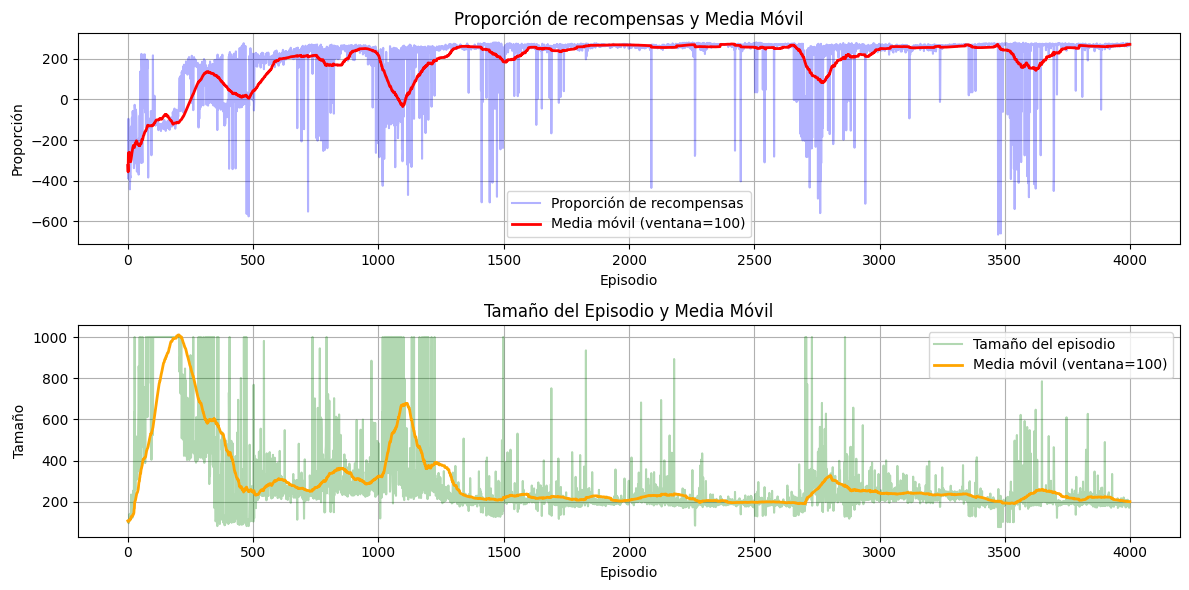

In [ ]:
plot(rewards_per_episode, episodes_sizes) #  Visualiza el análisis del aprendizaje (recompensas, tamaño de episodios, etc.)

En la primera gráfica podemos apreciar el cómo el algoritmo es capaz de obtener recompensas óptimas en un intervalo de tiempo más corto. En apenas 500 episodios ya alcanza recompensas de 200, es cierto que tiene algunas caídas a posteriori. Pero en líneas generales llegado cierto punto mantiene altas recompensas y en promedio mejor que el algoritmo anterior. Por lo que en general al inicio, las recompensas son bajas y tienen una alta variabilidad y  A medida que avanza el entrenamiento, las recompensas aumentan en promedio, aunque hay períodos de caída (posiblemente debido a cambios en la política exploratoria o ajustes en la estrategia del agente). La estabilización de la media móvil en valores positivos bastante altos indica que el agente ha aprendido una política que le permite obtener excelentes recompensas.

En la segunda se ve algo similar con un tamaño de episodio de 1000 pasos que apenas se alcanza en algún episodio y con un descenso largo y relativamente estable, quitando entre el episodio 1000 y 1500, se alcanza un tamaño promedio de episodio de unos 200 pasos. Por lo que  Inicialmente, los episodios son más largos, lo que indica que el agente está explorando más. A medida que mejora su estrategia, los episodios se vuelven más cortos en promedio, lo que sugiere que el agente ha aprendido a resolver la tarea de manera más eficiente.
Se observan fluctuaciones en el tamaño del episodio, lo que podría indicar momentos en los que el agente experimenta cambios en su política o encuentra nuevos estados exploratorios.

Por lo que tambien podemos extraer la conclusion de que los parametros elegidos son optimos y que permiten un balance optimo entre exploración y explotacion.

En conclusion el agente comienza con un aprendizaje caótico, reflejado en las grandes oscilaciones de recompensa y duración del episodio.
Con el tiempo, la política aprendida se vuelve más estable y eficiente, reflejada en una mayor recompensa promedio y una menor variabilidad en el tamaño de los episodios.
Sin embargo, hay algunos descensos en la recompensa media, lo que podría indicar desafíos en el aprendizaje o ajustes en la exploración.
En general, las gráficas muestran una buena progresión del aprendizaje, con evidencia de que el agente ha mejorado su desempeño con el tiempo.

Con esto podemos observar que el algoritmo es excelente y que parece adaptarse mejor al problema que Deep Q Learning, aunque a favor de deep q learning este es verdad que su aprendizaje es mas estable y con menos fluctuaciones. Esto se puede deber a que Deep Sarsa su enfoque es más conservador al actualizar los valores de acción. En Deep Q-Learning, la red objetivo calcula los valores Q futuros utilizando la acción con el mayor valor Q posible, lo que puede ser problemático en entornos estocásticos como Lunar Lander, donde las decisiones de acción pueden tener efectos impredecibles. Deep SARSA puede ser más robusto, ya que su actualización de Q-values está más alineada con las decisiones exploratorias del agente, lo que ayuda a mitigar la sobreestimación de los valores Q y permite una adaptación más suave a la incertidumbre del entorno. Esto puede hacer que Deep SARSA sea más efectivo, ya que el agente tiene en cuenta el hecho de que sus decisiones no siempre son perfectas, especialmente en situaciones inciertas y de alto riesgo como las que se encuentran en Lunar Lander.

Volvemos a generar un episodio en base a la politica optima

In [ ]:
# Obtener la política óptima, las acciones y los frames utilizando la función pi_star_from_Deep
pi, actions, frames = pi_star_from_Deep(env, agent)

# Renderizar el entorno para obtener la imagen final
img = env.render()

# Agregar la imagen final a la lista de frames
frames.append(img)

# Imprimir la política óptima, las acciones y la representación del entorno
print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida
 {(0.002297020051628351, 1.41813063621521, 0.232647106051445, 0.3204666078090668, -0.002654880052432418, -0.0526980459690094, 0.0, 0.0): 3, (0.0046554566361010075, 1.4247641563415527, 0.24004106223583221, 0.2948077619075775, -0.006804721895605326, -0.08300381898880005, 0.0, 0.0): 3, (0.007097912020981312, 1.430806040763855, 0.25056761503219604, 0.26848211884498596, -0.013059785589575768, -0.12511280179023743, 0.0, 0.0): 0, (0.009540557861328125, 1.4362483024597168, 0.25058668851852417, 0.24180839955806732, -0.019313327968120575, -0.12508240342140198, 0.0, 0.0): 0, (0.011983299627900124, 1.4410908222198486, 0.25060489773750305, 0.2151370346546173, -0.025566335767507553, -0.12507186830043793, 0.0, 0.0): 1, (0.014335823245346546, 1.4453442096710205, 0.23926159739494324, 0.18895922601222992, -0.029536142945289612, -0.07940352708101273, 0.0, 0.0): 1, (0.016591835767030716, 1.4490009546279907, 0.22715194523334503, 0.16249269247055054, -0.03107481077313423, -0.0307760

In [ ]:
create_gif(frames, "DeepSarsa-LunarLander.mp4", fps=24)  # saves the GIF locally

Moviepy - Building video DeepSarsa-LunarLander.mp4.
Moviepy - Writing video DeepSarsa-LunarLander.mp4



Moviepy - Done !
Moviepy - video ready DeepSarsa-LunarLander.mp4


Excelente resolución del problema, como podemos apreciar alcanza una solución en un tiempo muy inferior al Deep Q Learning. Por lo que se demuestra que su política es más óptima.

# Otras Soluciones

Viendo estas soluciones uno podría plantearse el sí es posible implementar otras soluciones vistas en clase como por ejemplo el uso de tiling o implementar algoritmos de aproximación lineal como Sarsa Semi Gradiente.

La primera idea ya la explicamos previamente al ser un problema de 8 variables continuas a la hora de discretear mediante tilings el espacio de observación se haría inmenso, complicando mucho la ejecución del algoritmo. Esto trae como consecuencia que haría que cualquier algoritmo que usara los tilings para este tipo de problema fuera directamente inviable. Esto por ejemplo se puede ver con un rápido cálculo supongamos un `n_tilings=10` y `bins=[10,10,10,10,10,10,10,10]` esto daría como resultado un espacio de observación de 10^9; además el número de bins tampoco es demasiado óptimo por lo que quizás debería de ser más alto, pero con eso podemos hacernos a una idea. Esto nos descarta el usar cualquier tipo de problema que no use aproximaciones. En aproximaciones no lineales como ya hemos visto la forma de solucionar esto es muy sencilla y es simplemente trabajar con el state sin discretizarlo y usar el formato de tensor que se adaptan de manera idónea a este tipo de variables, esto permite que la red aprenda una función que represente la relación entre el estado y las acciones.


Entonces nos queda la opción de implementar métodos de aproximación lineal como el Sarsa Semi Gradiente. En la teorías este algoritmo debería de ser capaz de completarlo, ya que en este algoritmo se obtiene Q como una estimación lineal mediante los weights, los cuales en este problema tendría un tamaño del espacio de observación por el número de acciones; es decir `8x4`. Para calcular el Q se podría hacer con el producto punto de dicha matriz weights.  

El problema viene a la hora de implementarlo, ya que SARSA Semi-Gradiente puede tener dificultades para resolver problemas complejos como **Lunar Lander** debido a la alta variabilidad y la necesidad de aprender políticas sofisticadas en entornos con espacios de estado grandes y dinámicos. En Lunar Lander, las interacciones del agente con el entorno son altamente no lineales y dependen de múltiples factores como la gravedad, la velocidad y la posición, lo que hace que la convergencia de SARSA sea lenta. Como SARSA utiliza un enfoque **basado en episodios**, puede necesitar muchos episodios para explorar adecuadamente el espacio de estado y encontrar la política óptima, lo que puede hacer que el proceso de aprendizaje sea muy costoso en tiempo y recursos.


Finalmente, el uso de **aproximaciones lineales** en SARSA Semi-Gradiente para representar la función de valor puede no ser suficiente para capturar las complejas relaciones entre el estado y las acciones en entornos como Lunar Lander. Sin una capacidad adecuada para modelar las dinámicas no lineales del entorno, el agente puede ser incapaz de aprender una política efectiva sin requerir un número excesivo de episodios, lo que hace que el proceso de entrenamiento sea ineficiente en términos de tiempo y muestra.


Esto lo hemos podido corroborar en diversas pruebas, ya que tras probar con infinidad de parámetros y cantidades de episodios enormes, el algoritmo simplemente no era capaz de converger a una política óptima. Sus recompensas promedio solían encontrarse entre -50 y -150.  Tampoco podemos asegurar que el algoritmo no sea capaz de resolverlo, ya que quizás con una cantidad de millones de episodios quizás sí que podría, pero llegados a esa solución el algoritmo se vuelve ineficiente en tiempo y recursos. Haciendo así mucho más atractivo otras soluciones como los métodos de aproximación no lineales como los implementados, los cuales además como hemos visto no necesitan de una red neuronal excesivamente profunda ni demasiados hiperparámetros. Por lo que simplemente para este problema se amoldan más para la complejidad y requerimientos del problema.

# Conclusiones

Las conclusiones obtenidas son bastante sencillas y simples.

- Problema de alta complejidad dado el uso de 8 variables continuas.
- Los algoritmos tabulares no son eficientes para este problema y necesitan del uso de la discretizacion.
- La discretización por tiling no es eficiente y dispara el tamaño de Q haciendo necesario un PC de altos recursos, sobre todo en memoria o directamente inviable. Imposibilitando así esta vía y el usarlo con algoritmos tabulares u otros algoritmos.
- Es necesario métodos de aproximación
- Los métodos de aproximación lineales no son suficientes para representar o capturar la complejidad del problema
- El algoritmo de Sarsa Semi Gradiente no es eficiente ni ha demostrado en ninguna de nuestras pruebas ser capaz de resolverlo, tal vez necesitaría una cantidad desmesurada de tiempo y episodios para lograrlo. Esto debido a que su algoritmo no se adapta bien a la complejidad del problema
- Métodos de aproximación no lineales demuestran buenos resultados y alcanzar la convergencia sin demasiada dificultad, inclusive no necesitan una red muy profunda ni demasiados episodios.
- Tanto Deep Sarsa como Deep Q learning son eficientes y se presentan como alternativas viables, aunque deep Sarsa se destaca obteniendo mejores resultados dado que parece que el formato del algoritmo se adapta mejor a la complejidad del problema.